In [2]:
import datasets 
import seaborn as sns
import matplotlib.pyplot as plt

/Users/mstankai/.pyenv/versions/3.12.7/envs/venv-python-minis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Getting the data

In [3]:
# get data from huggingface
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'default')   
df = dataset['train'].to_pandas()
df.describe()

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,hatespeech,hate_speech_score,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,annotator_age
count,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.00000,135556.000000,135556.000000,135556.000000,135556.000000,...,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135451.000000
mean,23530.416138,5567.097812,1.281352,2.954307,2.828875,2.56331,2.278638,2.698575,1.846211,1.052045,...,0.744733,-0.567428,1.034322,1.001052,-0.018817,0.300588,1.007158,1.011841,0.014589,37.910772
std,12387.194125,3230.508937,1.023542,1.231552,1.309548,1.38983,1.370876,0.898500,1.402372,1.345706,...,0.932260,2.380003,0.496867,0.791943,0.487261,0.236380,0.269876,0.675863,0.613006,11.641276
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-8.340000,0.100000,0.070000,-1.820000,0.020000,0.390000,0.280000,-1.578693,18.000000
25%,18148.000000,2719.000000,0.000000,2.000000,2.000000,2.00000,1.000000,2.000000,1.000000,0.000000,...,0.000000,-2.330000,0.710000,0.560000,-0.380000,0.030000,0.810000,0.670000,-0.341008,29.000000
50%,20052.000000,5602.500000,1.000000,3.000000,3.000000,3.00000,3.000000,3.000000,2.000000,0.000000,...,0.000000,-0.340000,0.960000,0.830000,-0.020000,0.340000,0.970000,0.850000,0.110405,35.000000
75%,32038.250000,8363.000000,2.000000,4.000000,4.000000,4.00000,3.000000,3.000000,3.000000,2.000000,...,2.000000,1.410000,1.300000,1.220000,0.350000,0.420000,1.170000,1.130000,0.449555,45.000000
max,50070.000000,11142.000000,3.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,...,2.000000,6.300000,5.900000,9.000000,1.360000,1.900000,2.010000,9.000000,0.987511,81.000000


In [4]:
print(df.shape)
df.info()

(135556, 131)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135556 entries, 0 to 135555
Columns: 131 entries, comment_id to annotator_sexuality_other
dtypes: bool(103), float64(19), int32(2), int8(1), object(6)
memory usage: 40.3+ MB


## Exploring and Imputing Null Values

In [5]:
(df.isnull().sum()*100/df.count()).sort_values(ascending=False)

annotator_age                0.077519
annotator_income             0.076041
annotator_ideology           0.019922
annotator_educ               0.012543
comment_id                   0.000000
                               ...   
target_religion_other        0.000000
target_religion_muslim       0.000000
target_religion_mormon       0.000000
target_religion_jewish       0.000000
annotator_sexuality_other    0.000000
Length: 131, dtype: float64

In [6]:
cols_w_nulls = df.columns[df.isna().any()].to_list()
cols_w_nulls

['annotator_educ', 'annotator_income', 'annotator_ideology', 'annotator_age']

In [7]:
df[cols_w_nulls].head()

,annotator_educ,annotator_income,annotator_ideology,annotator_age
0,college_grad_ba,<10k,neutral,25.0
1,some_college,<10k,neutral,30.0
2,some_college,100k-200k,slightly_conservative,41.0
3,high_school_grad,10k-50k,neutral,42.0
4,masters,10k-50k,neutral,27.0


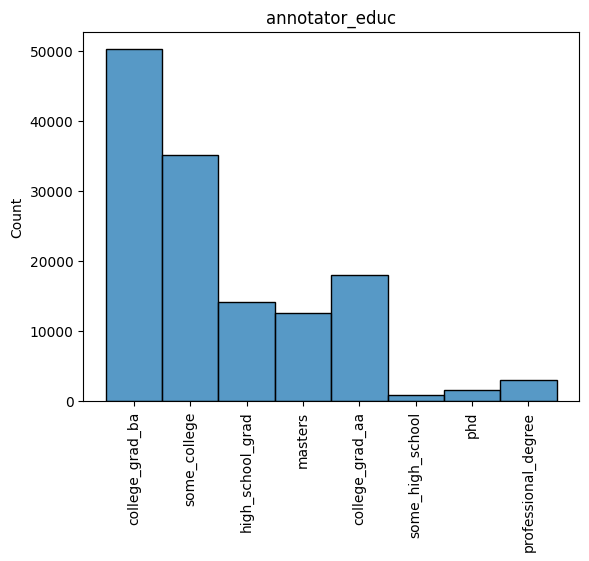

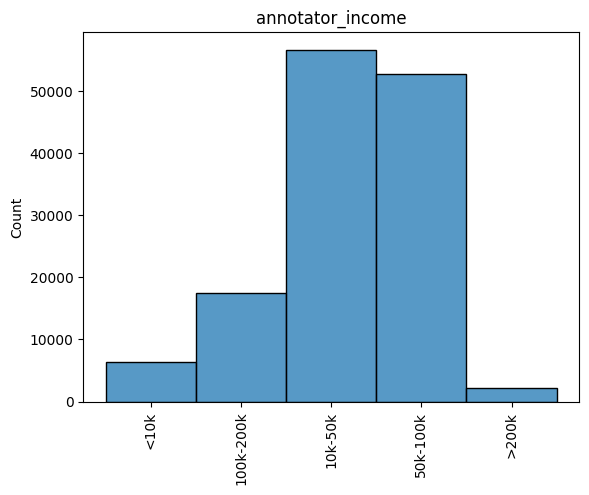

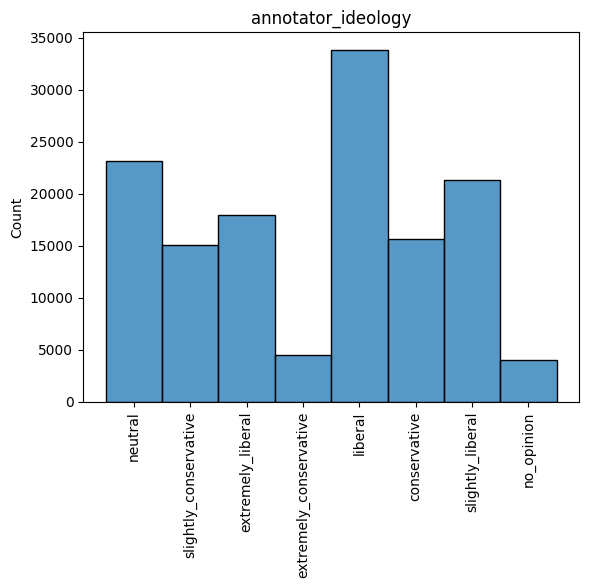

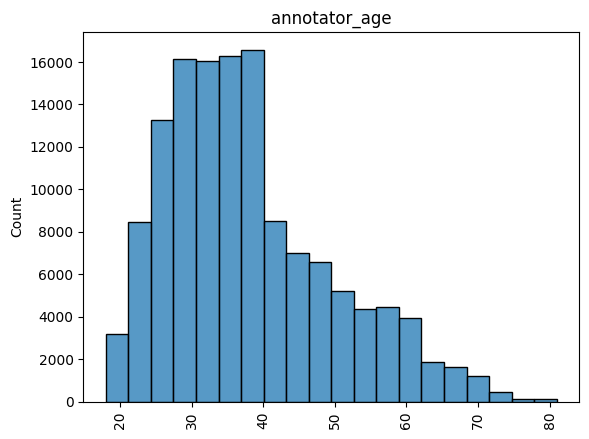

In [8]:
for c in cols_w_nulls:
    bins = 20
    if df[c].dtype == object:
        bins = df[c].nunique()
        
    sns.histplot(df[c], bins=bins)
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.title(c)
    plt.show()
    

In [9]:
print(df['annotator_age'].mean())
print(df['annotator_age'].median())

37.910772161150526
35.0


Since the missingness of the data is very small <0.1% I will impute the missing categorical values with the mode. Since the numerical values follow a Landau distribution, I will impute them with the median.

In [10]:
for c in cols_w_nulls:
    if df[c].dtype == object:
        val = df[c].mode().values[0]
    else:
        val = df[c].median()
    
    print(f"Fill NaNs in {c} with {val}")
    df[c] = df[c].fillna(val)

df.isna().sum().sort_values(ascending=False)

Fill NaNs in annotator_educ with college_grad_ba
Fill NaNs in annotator_income with 10k-50k
Fill NaNs in annotator_ideology with liberal
Fill NaNs in annotator_age with 35.0


comment_id                     0
annotator_income_50k-100k      0
annotator_income_<10k          0
annotator_education_phd        0
annotator_education_masters    0
                              ..
target_religion_other          0
target_religion_muslim         0
target_religion_mormon         0
target_religion_jewish         0
annotator_sexuality_other      0
Length: 131, dtype: int64

In [12]:
df.to_csv('../out.csv')